# Define the libraries

In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import timedelta
from scipy import signal

# Define Function

In [10]:
def PlotData(Begin,Duration,Mistake,OncourtFrame,OncourtVideo,Time,Data1,Data2,Figuur,player,df): 
    
    #Define starting en stopping positions for the CSV data
    Start = int((((OncourtFrame - OncourtVideo)*100) + Begin/10) - Mistake*100)
    Stop = int(Start + Duration*100)
    
    WheelRotationspeed = Data1[Start:Stop]
    FrameRotationspeed = Data2[Start:Stop]
    Timestamp = Time[Start:Stop]
    
    #Lowpass filter design for rotation and wheelspeed to improve accuracy of code (Butterworth filter)
    Order = 5 
    cutoff_freq = 1.5
    sampling_freq = 100
    sampling_duration = Duration
    
    normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
    numerator_coeffs, denominator_coeffs = signal.butter(Order, normalized_cutoff_freq)
    filtered_WheelRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, WheelRotationspeed)
    filtered_FrameRotationspeed = signal.lfilter(numerator_coeffs, denominator_coeffs, FrameRotationspeed)
    
    
    #Play with different operations to see clearer patterns
    Sub = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    Conv1 = filtered_FrameRotationspeed / filtered_WheelRotationspeed
    Conv2 = (abs(filtered_FrameRotationspeed)+abs(filtered_WheelRotationspeed))/filtered_WheelRotationspeed
    
    DiffFrame = np.diff(filtered_FrameRotationspeed,n=1)
    DiffFrame = np.insert(DiffFrame,0,0) #Add a 0 to beginning of array to fix size error
        
    DiffWheel = np.diff(filtered_WheelRotationspeed,n=1)
    DiffWheel = np.insert(DiffWheel,0,0)
    
    Multi = filtered_WheelRotationspeed + filtered_FrameRotationspeed
    
    #Visualize operations done
    fig, ax = plt.subplots(1,2)
    
    #ax[1,1].plot(Timestamp,Conv1,'r')
    ax[1].plot(Timestamp,abs(DiffFrame),'b')
    
    
    #Set all data into a datafram
    Data = pd.DataFrame({'Time':Timestamp,'WheelRotationspeed':filtered_WheelRotationspeed,
                         'FrameRotationspeed':filtered_FrameRotationspeed,
                         'Sub':Sub ,'Conv':Conv1, 'DiffFrame':DiffFrame, 'DiffWheel':DiffWheel}, 
                        columns=['Time', 'WheelRotationspeed','FrameRotationspeed','Sub','Conv','DiffFrame','DiffWheel'])
    
    #Convert data into chunks of n/100 of a second
    n = 50  #chunk row size
    Data_chunks = [Data[i:i+n] for i in range(0,Data.shape[0],n)]
    
    #Search for the sprints
    Startsprint = []
    Stopsprint = []
    Sprinting = False
    Stop = True
    
    #Use Sub en Conv to detect sprints
    for chunks in Data_chunks:
        if abs(chunks['Conv'].max()) < 3 and chunks['Sub'].mean() > 300 and Sprinting == False:
            Startsprint.append(chunks['Time'].min())
            Sprinting = True
            Stop = False
        elif abs(chunks['Conv'].max() < 3) and chunks['Sub'].mean() > 300:
            Sprinting = True
            Stop = False
        elif Stop == False:
            Stopsprint.append(chunks['Time'].min())
            Sprinting = False
            Stop = True
    
    #Use wheelrotation, framerotation and conv to detect rotations
    Startrotate = []
    Stoprotate = []
    Rotate = False
    Stop = True
    
    for chunks in Data_chunks:
        if abs(chunks['FrameRotationspeed'].max()) > 75 and abs(chunks['DiffFrame'].max()) > 4 and Rotate == False:
            Startrotate.append(chunks['Time'].min())
            Rotate = True
            Stop = False
        elif abs(chunks['FrameRotationspeed'].max()) > 75 and abs(chunks['DiffFrame'].max()) > 4:
            Rotate = True
            Stop = False
        elif Stop == False:
            Stoprotate.append(chunks['Time'].min())
            Rotate = False
            Stop = True
    
    print(Startrotate, Stoprotate)
    
    #Filter Sprints by lenght, if length is below 2 delete sprint
    Deleted = 0
    
    if len(Startsprint) > len(Stopsprint):
        Startsprint.pop(-1)
    
    if len(Startsprint) == len(Stopsprint):
        for i in range(0,len(Startsprint)-1):
            if (Stopsprint[i-Deleted] - Startsprint[i-Deleted]) < 2:
                Startsprint.pop(i-Deleted)
                Stopsprint.pop(i-Deleted)
                Deleted = Deleted + 1

    #Plot graph
    ax[0].plot(Timestamp,WheelRotationspeed,'r',Timestamp,FrameRotationspeed,'b')
    #ax[0,1].plot(Timestamp,WheelRotationspeed,'r',Timestamp,FrameRotationspeed,'b')
    
    #Plot the vertical lines in plot 1
    for Start in Startsprint:
        ax[0].axvline(x=Start, color = 'g')
    for Stop in Stopsprint:
        ax[0].axvline(x=Stop, color = 'm')
    #ax[0,0].legend(['Wheel Rotation Speed','Frame Rotation Speed'])
    ax[0].set_xlabel('Time (sec)')
    ax[0].set_title("Fast Defence " + str(Figuur) + ", " + str(player) + ", Video Time = " 
                      + str(timedelta(seconds=(int(Begin/1000)-Mistake))))
    
    #Plot the vertical lines in plot 2
    #for Start in Startrotate:
    #    ax[0,1].axvline(x=Start, color = 'g')
    #for Stop in Stoprotate:
    #    ax[0,1].axvline(x=Stop, color = 'm')
    

# Visualize Data
## Define player and match

In [11]:
Player = 15
Game = 2

## Insert Data player

In [12]:
df_Player = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '.csv')
df_Player.columns = ['frAcc','frRoAcc','frDispl','frRoAng','frSpeed','timeLine','frameRotationalSpeedX','frameRotationalSpeedY','frameRotationalSpeedZ','wheelRotationalSpeedX','wheelRotationalSpeedY','wheelRotationalSpeedZ','frRoSpeed']
df_Action = pd.read_csv('Ned_DUI_Game_' + str(Game) + '.csv')
df_Player

,frAcc,frRoAcc,frDispl,frRoAng,frSpeed,timeLine,frameRotationalSpeedX,frameRotationalSpeedY,frameRotationalSpeedZ,wheelRotationalSpeedX,wheelRotationalSpeedY,wheelRotationalSpeedZ,frRoSpeed
0,0.000000,0.0,0.0,0.00000,0.000000,0.01,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
1,0.000000,0.0,0.0,0.00000,0.000000,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
2,0.000000,0.0,0.0,0.00000,0.000000,0.03,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
3,0.000000,0.0,0.0,0.00000,0.000000,0.04,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
4,0.000000,0.0,0.0,0.00000,0.000000,0.05,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
860405,-0.002098,6556.8,-1946.6,-0.18538,-0.000787,8604.10,1.0500,0.85556,-1.0500,1.4000,1.16670,-1.5867,-0.40135
860406,-0.026347,6556.8,-1946.6,-0.18939,-0.000808,8604.10,1.0920,0.93100,-1.0710,1.4000,1.09200,-1.6240,-5.03910
860407,0.012933,6556.8,-1946.6,-0.23979,-0.001071,8604.10,1.1690,0.95900,-1.1200,1.4000,1.08110,-1.5089,NaN
860408,NaN,NaN,NaN,NaN,NaN,NaN,1.1433,0.93333,-1.0967,1.4000,1.08500,-1.4700,NaN


## Define boundaries
### Get Timestamps from CSV

In [13]:
df_Action_Player = df_Action.loc[df_Action["Players Group Box"] == ("Player " + str(Player))]
df_Action_Player_Fast_defence = df_Action_Player.loc[df_Action_Player["Player"] == "Fast break"]#.iloc[::-1]
Timestamp = df_Action_Player_Fast_defence.Position.to_numpy()
print(len(Timestamp))
Timestamp

7


array([ 268440,  304760,  788800, 1617800, 3143280, 3750200, 3789200])

### Synchronize
Times consist of the oncourt times in the video and the oncourt frames in Matlab

In [14]:
df_Sync = pd.read_csv('Sync_match_' + str(Game) + '.csv')
df_Sync_Player = df_Sync.loc[df_Sync["Player"] == Player]
Times = df_Sync_Player[["Video","Matlab"]].to_numpy()
Times[0][1]

3580.0

In [15]:
Error = [6,6,6,4,6,6,6,6,6,8,8]
print(len(Error))

11


### Visualize

[3804.6, 3809.6] [3805.1]
[3832.4] [3832.9]
[4325.9] [4326.4]
[5145.5] [5146.0]
[7157.5, 7165.0] [7158.5, 7165.5]
[7774.8] [7775.8]
[] []


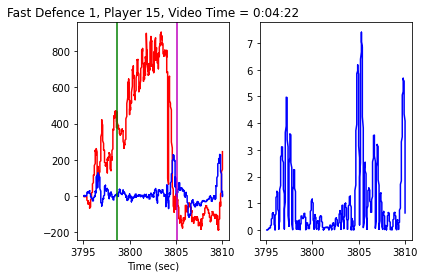

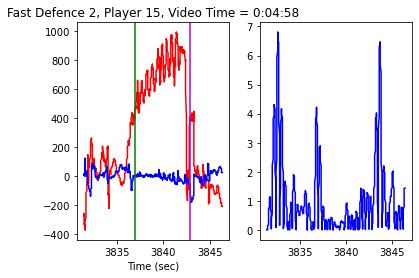

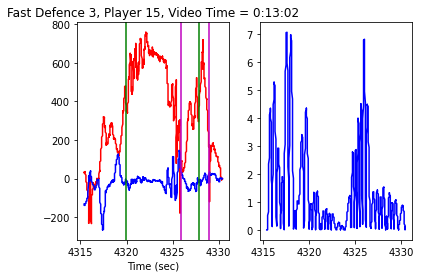

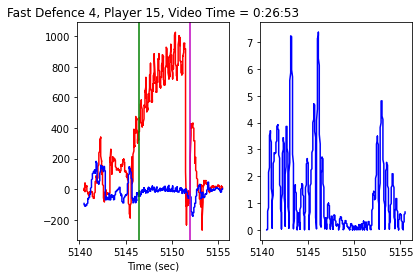

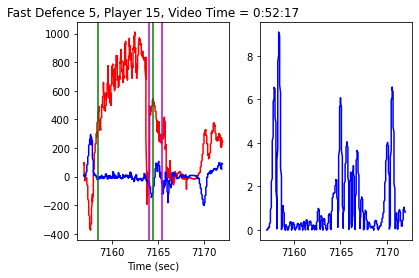

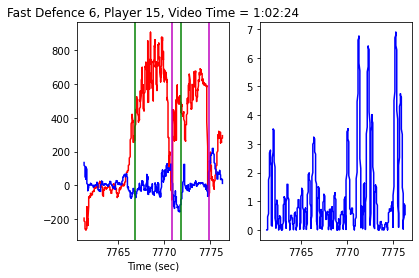

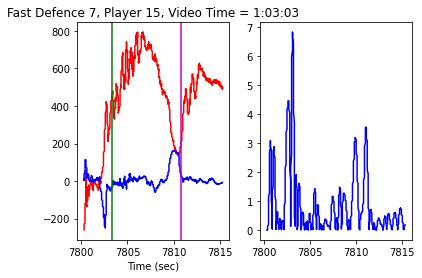

In [16]:
Quator = 0;
for i in range(0,len(Timestamp)):
    if Quator < (len(Times)-1):
        if Timestamp[i] >= (Times[Quator+1][0] * 1000):
            Quator = Quator + 1
    PlotData(Timestamp[i], 15, Error[i], Times[Quator][1], Times[Quator][0], df_Player.timeLine.to_numpy(), 
             df_Player.wheelRotationalSpeedX.to_numpy(), 
             df_Player.frameRotationalSpeedZ.to_numpy(),
             i+1,('Player ' + str(Player)),df_Action)